# Sentiment Analysis

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Regex
import re 

# NLTK
import nltk #for text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download("wordnet")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import  MultinomialNB
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV


## Functions to be used

In [33]:
def txt_to_df(file_path):
    """
    This function converts the text files to dataframe.
    Parameters:
        file_path (str): Path of the dataset.
    Returns:
        df: Pandas dataframe.
    """
    # Initialize empty lists to hold the columns
    tweet_ids = []
    sentiments = []
    tweet_texts = []

    # Read the file line by line and split by tabs to populate the lists
    with open(file_path, 'r', encoding='unicode-escape') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:  # Only consider lines with all three components
                tweet_ids.append(parts[0])
                sentiments.append(parts[1])
                tweet_texts.append(parts[2])

    # Create the DataFrame using the populated lists
    df = pd.DataFrame({
        'id': tweet_ids,
        'sentiment': sentiments,
        'tweet': tweet_texts
    })

    return df


# Experiments done
- Changed preprocessing method
    - (`preprocess_v1`) Did not remove following words after @ and #
    - (`preprocess_v2`) Removed following words after @ and #
    - (`preprocess_v3`) Used spaCy
    - Compare performance of what I made vs perfomance of spaCy
- Compared performance between different models
- Hyperparameter tuning: GridSearch CV


In [4]:
# Reading data and concatenating
df_1 = txt_to_df('datasets/twitter-2013dev-A.txt') 
df_2 = txt_to_df('datasets/twitter-2013test-A.txt') 
df_3 = txt_to_df('datasets/twitter-2013train-A.txt') 
df_4 = txt_to_df('datasets/twitter-2014test-A.txt') 
df_5 = txt_to_df('datasets/twitter-2015test-A.txt') 
df_6 = txt_to_df('datasets/twitter-2015train-A.txt') 
df_7 = txt_to_df('datasets/twitter-2016dev-A.txt') 
df_8 = txt_to_df('datasets/twitter-2016devtest-A.txt') 
df_9 = txt_to_df('datasets/twitter-2016test-A.txt') 
df_10 = txt_to_df('datasets/twitter-2016train-A.txt') 

In [5]:
# Concatenate dataframes
tweets_df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10],axis=0)
tweets_df

,id,sentiment,tweet
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver..."
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...
...,...,...,...
5995,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
5996,639979760735662080,neutral,everyone who sat around me at metlife was so a...
5997,640196838260363269,neutral,what giants or niners fans would wanna go to t...
5998,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


In [6]:
# Checks for duplicate rows
print(tweets_df.duplicated().values.any())

True


In [7]:
# Remove duplicate rows
tweets_df = tweets_df.drop_duplicates()

In [8]:
# Check for duplicate rows
print(tweets_df.duplicated().values.any())
tweets_df

False


,id,sentiment,tweet
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver..."
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...
...,...,...,...
5995,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
5996,639979760735662080,neutral,everyone who sat around me at metlife was so a...
5997,640196838260363269,neutral,what giants or niners fans would wanna go to t...
5998,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


In [9]:
# Check if sentiment is correct unique in the dataframe
tweets_df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Text(0.5, 1.0, 'Sentiment Distribution')

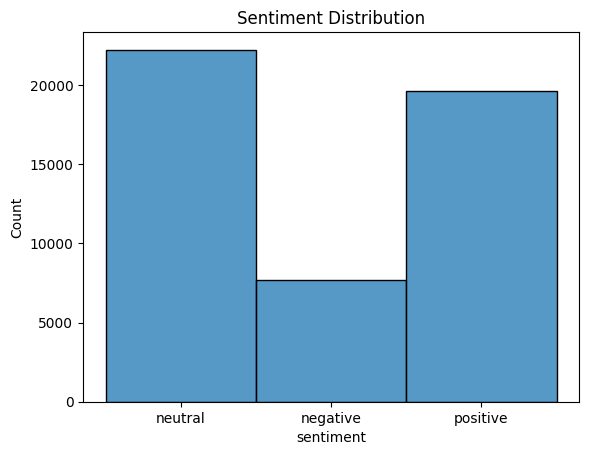

In [10]:
# Plot number of sentiments to get an idea of the distribution
plt.figure()
sns.histplot(data=tweets_df, x=tweets_df['sentiment'])
plt.title("Sentiment Distribution")

We can see from the data that there is an imbalance in the dataset.

Before anything else, let us preprocess the dataset. Three types of preprocessing techniques will be applied The following will be done to apply preprocessing on the data:
1. Unicode escape sequence `\u` will be decoded.
2. Punctuations will be  removed.
3. Links will be removed.
4. `#` and `@` characters will also be removed from the texts, but the word following it will be retained.
5. Numbers will be removed but numbers following letters (e.g. 2nd, 16th) will be retained

After cleaning the text, preprocessing, the following steps will be done:
1. Words will be tokenized.
2. After tokenization, words will be lemmatized
3. After lemmatization, stop

In [1]:
# Copy DF apply different preprocessing techniques onto different dataframes
preprocess_v1_tweets_df = tweets_df.copy()
preprocess_v2_tweets_df = tweets_df.copy()
preprocess_v3_tweets_df = tweets_df.copy()

NameError: name 'tweets_df' is not defined

In [11]:
def clean_text(text):
    """
    Removes @, #, and punctuation marks from the text.

    Parameters:
        text (str): tokenized tweet.
    Returns:
        str: The cleaned tweet text.
    """
    # Convert text to lowercase
    text = text.lower()

    # Replace @, #, links and non-word characters with a space
    # pattern = re.compile(r'(http|https)://[^\s]+|[^\w\s@#]|[@#]|\d+:\d+|\d+(?![a-zA-Z])|_')
    pattern = re.compile(r'(http|https)://[^\s]+|[^\w\s@#]|(@\w+|#\w+)|\d+:\d+|\d+(?![a-zA-Z])|_')
    cleaned_text = pattern.sub(' ', text)

    

    # Remove extra spaces
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text

def preprocess_text_v1(text):
    """
    Preprocesses the text.

    Parameters:
        text (str): tokenized tweet.
    Returns:
        str: The cleaned tweet text.
    """
    # Clean text
    cleaned_text = clean_text(text)
    
    # Tokenize the text
    words = word_tokenize(cleaned_text)
    filtered_words = []
    
    # Remove English Stop Words
    stop_words = stopwords.words('English')
    stop_words.remove("not")
    stop_words = set(stop_words)
    
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    # print("Filtered: ", filtered_words)
    
    # Lemmatize the text for nouns
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in filtered_words:
        lemmatized_word = lemmatizer.lemmatize(word, pos='n')
        lemmatized_words.append(lemmatized_word) 
    # print("Lemmatized words:", lemmatized_words)

    # Lemmatize for verbs
    final_lemmatized_words = []
    for word in lemmatized_words:
        lemmatized_word = lemmatizer.lemmatize(word, pos='v')
        final_lemmatized_words.append(lemmatized_word)
    
    processed_text = ' '.join(final_lemmatized_words)
    return processed_text


In [33]:
preprocess_text_v1("I am not happy @marcos")

'not happy'

### Preprocess Using spaCy

In [24]:
import spacy

def preprocess_text(texts):
    """
    Preprocess a list of texts using spaCy for sentiment analysis.
    This optimized version uses spaCy's pipe method for batch processing.
    
    Parameters:
        texts (list): List of original tweet texts.
    
    Returns:
        list: List of preprocessed texts.
    """
    # Load the spaCy model and disable parser, and named entity recognizer
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    preprocessed_texts = []
    
    # Use spaCy's pipe method for batch processing
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = []
        for token in doc:
            if not (token.is_stop or token.is_punct):
                tokens.append(token.lemma_.lower())
        preprocessed_texts.append(' '.join(tokens))
    
    return preprocessed_texts


In [25]:
preprocess_text(["i am not happy"])

['happy']

In [20]:
# # Apply the preprocessing function to the 'Tweet_Text' column of the DataFrame
# tweets_df['preprocessed_text'] = preprocess_text(tweets_df["tweet"].tolist())

# # Show the first few rows to confirm preprocessing
# tweets_df.head()


C:\Users\WDIMACULANGAN\AppData\Local\Temp\ipykernel_18900\3477288246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['preprocessed_text'] = preprocess_text(tweets_df["tweet"].tolist())


,id,sentiment,tweet,preprocessed_text
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver...",won match getin plus tomorrow busy day awarene...
1,263791921753882624,neutral,Some areas of New England could see the first ...,area new england flake season tuesday
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,@francesco_con40 2nd bad qb definitely tony ro...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,thailand washington president barack obama vow...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...,you hear tony romo dress halloween giants quat...


In [ ]:

# # WordNetLemmatizer().lemmatize("us", pos='n')
# # text = "@marcos the 2nd not 2 Done with the updates! Hurray for me!! Ahehe ^_^ =) Now I can go to sleep. Six loads pa ang bubunuin ko tomorrow...Aja! God bless everyone:)"
# text = "hello world"
# temp = df_1.copy()
# temp["preprocessed"] = preprocess_text(temp["tweet"].tolist())
# temp

In [12]:
tweets_df['preprocessed_text'] = tweets_df['tweet'].apply(preprocess_text_v1)
tweets_df
# tweets_df.to_csv("sample.csv")

C:\Users\WDIMACULANGAN\AppData\Local\Temp\ipykernel_21624\3355106610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['preprocessed_text'] = tweets_df['tweet'].apply(preprocess_text_v1)


,id,sentiment,tweet,preprocessed_text
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a ver...",match plus tomorrow busy day awareness day deb...
1,263791921753882624,neutral,Some areas of New England could see the first ...,area new england could see first flake season ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,2nd worst qb definitely tony romo man like sha...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,washington u president barack obama vow wednes...
4,263816256640126976,neutral,Did y’all hear what Tony Romo dressed up as fo...,hear tony romo dress halloween giant quaterbac...
...,...,...,...,...
5995,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...,ok good know punt metlife december task hope he
5996,639979760735662080,neutral,everyone who sat around me at metlife was so a...,everyone sit around metlife annoy didnt let ru...
5997,640196838260363269,neutral,what giants or niners fans would wanna go to t...,giant niner fan would wan na go sunday night g...
5998,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...,anybody want ticket tomorrow colombia v peru m...


## Model Selection and Training

In [13]:
vectorizer = TfidfVectorizer(max_features=1000)
matrix = vectorizer.fit_transform(tweets_df['preprocessed_text'])
# Save the vectorizer
dump(vectorizer, 'models/tfidf_vectorizer_v2.joblib')
print(matrix)

  (0, 231)	0.7336334594045433
  (0, 225)	0.3996946308999094
  (0, 895)	0.1627684133105418
  (0, 684)	0.3983916073446227
  (0, 556)	0.3417846106799487
  (1, 911)	0.4236499102111126
  (1, 774)	0.44305208191221374
  (1, 321)	0.41009150417983975
  (1, 777)	0.3136262701074911
  (1, 201)	0.4736817337841309
  (1, 610)	0.3651229139188726
  (2, 864)	0.2734695023602609
  (2, 430)	0.3527426552954875
  (2, 288)	0.2900200176237172
  (2, 80)	0.32849618801971975
  (2, 792)	0.3358444220989191
  (2, 517)	0.19637452977512262
  (2, 546)	0.24908698738240925
  (2, 897)	0.33299644213523827
  (2, 236)	0.3507345875053891
  (2, 975)	0.34307865187952763
  (2, 4)	0.2091951061631062
  (3, 935)	0.45514605044160544
  (3, 952)	0.35021754738315175
  (3, 630)	0.4089368061556929
  :	:
  (49589, 571)	0.479272069461753
  (49589, 60)	0.4052859890147784
  (49589, 37)	0.4177904830486409
  (49589, 808)	0.31395588452095846
  (49589, 511)	0.34888429083682754
  (49589, 618)	0.25043401186959835
  (49589, 288)	0.3853400092087365


In [14]:
features = matrix

labels = tweets_df['sentiment']

# X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=77, test_size=0.3, shuffle=True)

# print(X_train)
# print(y_train)

In [ ]:
# lr_model = LogisticRegression()
# lr_model.fit(X_train, y_train)

# predictions = lr_model.predict(X_test)

# print(classification_report(y_test, predictions))

The performance is inadequate, therefore let's try to use a random under sampler.

In [15]:
labels.value_counts()

sentiment
neutral     22240
positive    19647
negative     7706
Name: count, dtype: int64

In [16]:
# Random Undersampler
rus = RandomUnderSampler(random_state=0)

X_res, y_res = rus.fit_resample(features, labels)

print(y_res.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=77, test_size=0.3, shuffle=True)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_test)

print(classification_report(y_test, predictions))

sentiment
negative    7706
neutral     7706
positive    7706
Name: count, dtype: int64
              precision    recall  f1-score   support

    negative       0.62      0.63      0.63      2336
     neutral       0.52      0.53      0.53      2304
    positive       0.64      0.62      0.63      2296

    accuracy                           0.59      6936
   macro avg       0.59      0.59      0.59      6936
weighted avg       0.59      0.59      0.59      6936



c:\Users\WDIMACULANGAN\Desktop\Activity\sentiment-analysis\src\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Since the other metrics have improved after balancing the dataset, let us try using other models

In [17]:
# Initialize Models

svm = SVC(random_state=77, kernel='linear', probability=True)
dt = DecisionTreeClassifier(random_state=77)
rf = RandomForestClassifier(random_state=77)
nb = MultinomialNB()
models = {'SVM': svm, 'Decision Trees': dt,"Random Forest": rf, "Naive Bayes": nb}
trained_models = {}

print(y_train.value_counts())

for name, model in models.items():
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(f"{name}", classification_report(y_test, prediction))
    print('\n')
    # Save the model
    dump(model, f"{name}_model.joblib")


sentiment
positive    5410
neutral     5402
negative    5370
Name: count, dtype: int64
SVM               precision    recall  f1-score   support

    negative       0.61      0.63      0.62      2336
     neutral       0.52      0.56      0.54      2304
    positive       0.66      0.59      0.62      2296

    accuracy                           0.59      6936
   macro avg       0.60      0.59      0.59      6936
weighted avg       0.60      0.59      0.59      6936



Decision Trees               precision    recall  f1-score   support

    negative       0.51      0.51      0.51      2336
     neutral       0.43      0.43      0.43      2304
    positive       0.52      0.53      0.52      2296

    accuracy                           0.49      6936
   macro avg       0.49      0.49      0.49      6936
weighted avg       0.49      0.49      0.49      6936



Random Forest               precision    recall  f1-score   support

    negative       0.58      0.63      0.61      2336
     

The following are the saved result
```
sentiment
positive    2995
negative    2981
neutral     2909
Name: count, dtype: int64
SVM               precision    recall  f1-score   support

    negative       0.59      0.64      0.61      1250
     neutral       0.55      0.58      0.56      1322
    positive       0.67      0.57      0.62      1236

    accuracy                           0.60      3808
   macro avg       0.60      0.60      0.60      3808
weighted avg       0.60      0.60      0.60      3808



Decision Trees               precision    recall  f1-score   support

    negative       0.49      0.53      0.51      1250
     neutral       0.50      0.46      0.48      1322
    positive       0.55      0.54      0.54      1236

    accuracy                           0.51      3808
   macro avg       0.51      0.51      0.51      3808
weighted avg       0.51      0.51      0.51      3808



Random Forest               precision    recall  f1-score   support

    negative       0.56      0.61      0.58      1250
     neutral       0.54      0.56      0.55      1322
    positive       0.66      0.58      0.62      1236

    accuracy                           0.58      3808
   macro avg       0.59      0.58      0.58      3808
weighted avg       0.59      0.58      0.58      3808



Naive Bayes               precision    recall  f1-score   support

    negative       0.59      0.64      0.62      1250
     neutral       0.55      0.51      0.53      1322
    positive       0.60      0.59      0.60      1236

    accuracy                           0.58      3808
   macro avg       0.58      0.58      0.58      3808
weighted avg       0.58      0.58      0.58      3808


```

### Using test and train datasets

## Hyperparameter Tuning

In [ ]:
def preform_gridsearchcv(model_name, model, model_params, X_train, y_train):
    grid_search_model = GridSearchCV(model, model_params, cv=5)
    grid_search_model.fit(X_train, y_train)

    # Get best parameters
    best_params = grid_search_model.best_params_
    best_estimator = grid_search_model.best_estimator_
    print(f"{model_name} Best Parameters:")
    print(best_params)
    print(f"{model_name} Best Estimators:")
    print(best_estimator)


In [18]:
# Declare models again
svm = SVC(random_state=77, probability=True)
dt = DecisionTreeClassifier(random_state=77)
rf = RandomForestClassifier(random_state=77)
nb = MultinomialNB()

In [ ]:
# # Naive Bayes Hyperparameter Tuning
# naive_bayes_params = {'alpha': [0.1, 0.5, 1, 2]}
# preform_gridsearchcv("Naive Bayes", nb, naive_bayes_params, X_train, y_train)

# # SVM
# svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
# preform_gridsearchcv("SVM", svm, svm_params, X_train, y_train)

# # Decision Trees
# decision_tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30, 40, 50]}
# preform_gridsearchcv("Decision Trees", dt, decision_tree_params, X_train, y_train)

# # Random Forest
# random_forest_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30]}
# preform_gridsearchcv("Random Forest", rf, random_forest_params, X_train, y_train)


```
Naive Bayes Best Parameters:
{'alpha': 2}
Naive Bayes Best Estimators:
MultinomialNB(alpha=2)
SVM Best Parameters:
{'C': 1, 'kernel': 'rbf'}
SVM Best Estimators:
SVC(C=1, probability=True, random_state=77)
Decision Trees Best Parameters:
{'criterion': 'gini', 'max_depth': None}
Decision Trees Best Estimators:
DecisionTreeClassifier(random_state=77)
Random Forest Best Parameters:
{'max_depth': None, 'n_estimators': 100}
Random Forest Best Estimators:
RandomForestClassifier(random_state=77)
```


In [19]:
# Tuned
svm = SVC(C=1, kernel= 'rbf', random_state=77, probability=True)
dt = DecisionTreeClassifier(criterion= 'gini', max_depth= None, random_state=77)
rf = RandomForestClassifier(max_depth= None, n_estimators=100, random_state=77)
nb = MultinomialNB(alpha=2)

models = {'SVM': svm, 'Decision Trees': dt,"Random Forest": rf, "Naive Bayes": nb}
trained_models = {}

print(y_train.value_counts())

for name, model in models.items():
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(f"{name}", classification_report(y_test, prediction))
    print('\n')
    # Save the model
    dump(model, f"{name}_model.joblib")

sentiment
positive    5410
neutral     5402
negative    5370
Name: count, dtype: int64
SVM               precision    recall  f1-score   support

    negative       0.62      0.64      0.63      2336
     neutral       0.51      0.55      0.53      2304
    positive       0.66      0.59      0.62      2296

    accuracy                           0.59      6936
   macro avg       0.60      0.59      0.59      6936
weighted avg       0.60      0.59      0.59      6936



Decision Trees               precision    recall  f1-score   support

    negative       0.51      0.51      0.51      2336
     neutral       0.43      0.43      0.43      2304
    positive       0.52      0.53      0.52      2296

    accuracy                           0.49      6936
   macro avg       0.49      0.49      0.49      6936
weighted avg       0.49      0.49      0.49      6936



Random Forest               precision    recall  f1-score   support

    negative       0.58      0.63      0.61      2336
     

In [ ]:
user_input = "Going to a bulls game next Thursday"

cleaned_input = preprocess_text(user_input)
cleaned_input

In [32]:
loaded_model = load('SVM_model.joblib')
vectorizer = load('models/tfidf_vectorizer_v2.joblib')
user_input = "I love death"

cleaned_input = preprocess_text_v1(user_input)
print(cleaned_input)
user_input_tfidf = vectorizer.transform([cleaned_input])

predicted_label = loaded_model.predict(user_input_tfidf)

probability_estimates = loaded_model.predict_proba(user_input_tfidf)

print("Predicted Label:", predicted_label)
print("Probability Estimates:", probability_estimates)


love death
Predicted Label: ['positive']
Probability Estimates: [[0.2033029  0.03811256 0.75858454]]
